In [788]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')

# Reading and analysing the data

In [789]:
leads_df = pd.read_csv("Leads.csv")
leads_df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [790]:
leads_df.shape

(9240, 37)

### Data duplication checks

`PROSPECT ID` and `LEAD NUMBER` seem to be primary key of the dataset and should be unique. Following block checks if there are any duplicates in dataset

In [791]:
if sum(leads_df.duplicated(subset = 'Prospect ID')) == 0:
    print("There are no duplicates in column Prospect ID")
else:
    print("Duplicates found in column Prospect ID")

There are no duplicates in column Prospect ID


In [792]:
if sum(leads_df.duplicated(subset = 'Lead Number')) == 0:
    print("There are no duplicates in column Lead Number")
else:
    print("Duplicates found in column Lead Number")

There are no duplicates in column Lead Number


### Missing values checks

In [793]:
#Select value in any column is mainly because user has not selected any value from dropdown. So, it can be considered as null.
leads_df = leads_df.replace({'Select':np.nan})

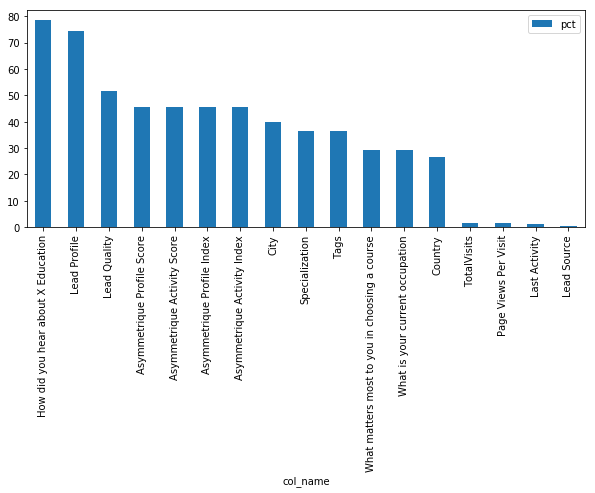

In [794]:
# Calculate % of missing values in each dataset
missing_values = round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)
missing_values_df = pd.DataFrame(missing_values,columns=['pct']).reset_index()
missing_values_df.columns=['col_name','pct']
missing_values_df[missing_values_df.pct>0].sort_values(by="pct",ascending=False).plot(kind="bar",x="col_name",figsize=(10,4))


In [795]:
#deleting the rows which are having more than 30% of missing values in rows it means out of 37 i will keep the rows with
#atleast 25 colums having the value
leads_df.dropna(thresh=25,inplace=True)

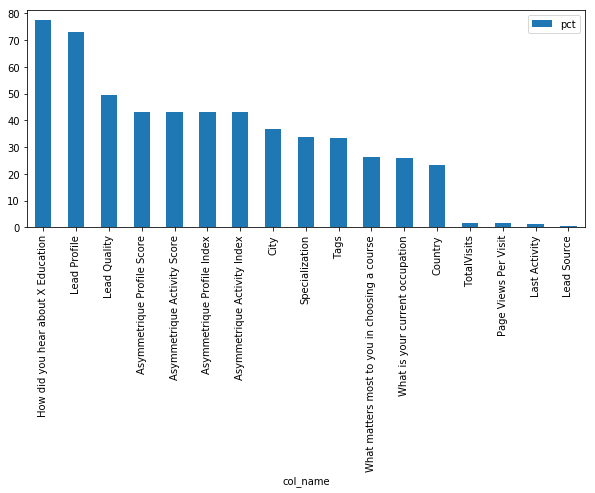

In [796]:
#Checking the stats again
missing_values = round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)
missing_values_df = pd.DataFrame(missing_values,columns=['pct']).reset_index()
missing_values_df.columns=['col_name','pct']
missing_values_df[missing_values_df.pct>0].sort_values(by="pct",ascending=False).plot(kind="bar",x="col_name",figsize=(10,4))


More than 70% data `Lead Profile`column is either null or not selected by the customers. So, its better to drop the column.

In [797]:
leads_df.drop(columns="Lead Profile",inplace=True)
#leads_df.drop(columns='How did you hear about X Education',inplace=True)

# Replace "Select" and null values with "Others"
leads_df["How did you hear about X Education"].replace({np.nan:"Others","Other":"Others"},inplace=True)
leads_df["Specialization"].replace({np.nan:"Others"},inplace=True)
leads_df["What is your current occupation"].replace({"Other":"Others",np.nan:"Others"},inplace=True)

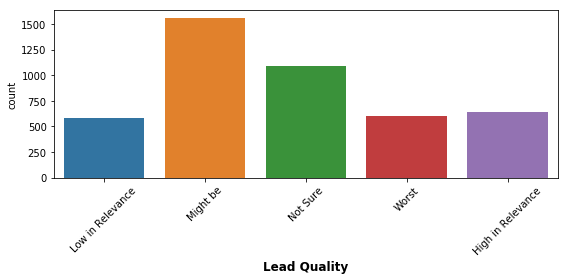

In [798]:
# Plot count of distinct values in Lead Quality column 
fig = plt.figure(figsize=(8,4))
ax = sns.countplot(x="Lead Quality",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Lead Quality",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()


`Lead Quality` column indicates the quality of lead based on the data and intuition the employee who has been assigned to the lead. So, We can impute null values in `Lead Quality` column with **Not Sure** value as we do not know quality of the lead. Also, this is possibly not a drop down column in the form. This column's data is derived on the intution of other data points.

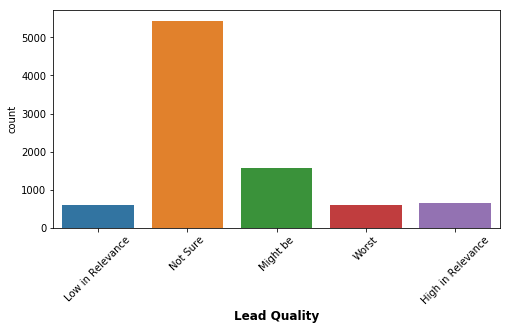

In [799]:
#Replacing null values with "Not Sure" in Lead Quality column
leads_df["Lead Quality"].fillna("Not Sure",inplace=True)

#Plot after missing value imputation in Lead Quality column
fig = plt.figure(figsize=(8,4))
ax = sns.countplot(x="Lead Quality",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Lead Quality",fontsize=12,fontweight='bold')
fig.show()

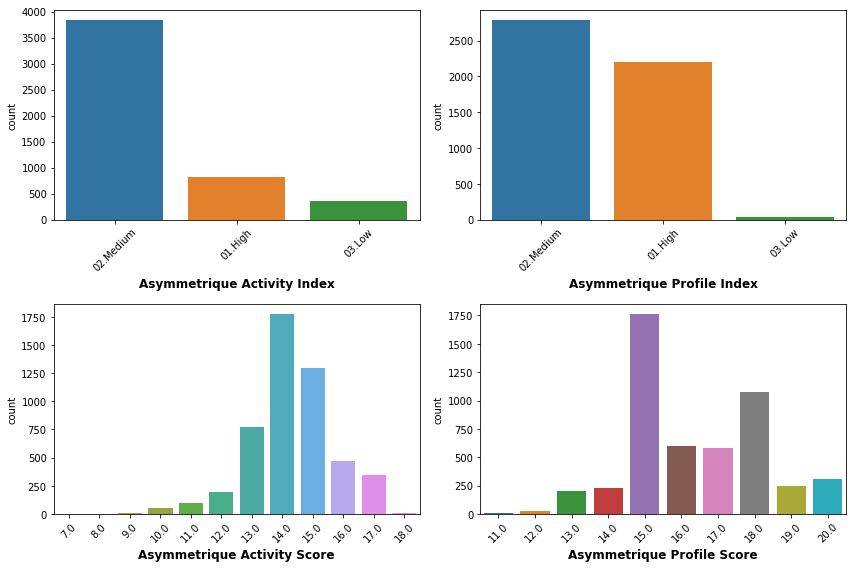

In [800]:
fig = plt.figure(figsize=(12,8))
plt.subplot(221)
ax = sns.countplot(x="Asymmetrique Activity Index",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Asymmetrique Activity Index",fontsize=12,fontweight='bold')
plt.subplot(222)
ax = sns.countplot(x="Asymmetrique Profile Index",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Asymmetrique Profile Index",fontsize=12,fontweight='bold')
plt.subplot(223)
ax = sns.countplot(x="Asymmetrique Activity Score",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Asymmetrique Activity Score",fontsize=12,fontweight='bold')
plt.subplot(224)
ax = sns.countplot(x="Asymmetrique Profile Score",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("Asymmetrique Profile Score",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()

An index and score assigned to each customer based on their activity and their profile. Also, there is no specific pattern how scores and indexes are calculated. So, It will be highly difficult to predict value to be imputed in null records. So, it is better to drop columns `Asymmetrique Activity Index`,`Asymmetrique Profile Index`,`Asymmetrique Activity Score`,`Asymmetrique Profile Score`.

In [801]:
leads_df.drop(axis=1,columns=["Asymmetrique Activity Index","Asymmetrique Profile Index","Asymmetrique Activity Score",\
                              "Asymmetrique Profile Score"],inplace=True)

Around 23.18413597733711 % have having missing values


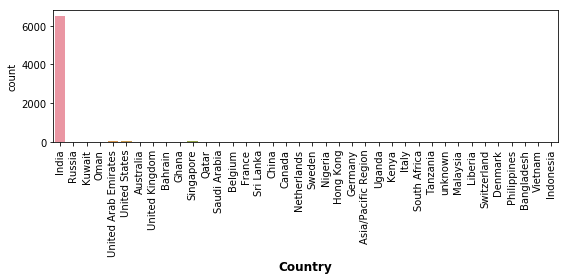

In [802]:
fig = plt.figure(figsize=(8,4))
ax = sns.countplot(x="Country",data=leads_df)
plt.xticks(rotation=90)
plt.xlabel("Country",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()
print("Around",len(leads_df[leads_df['Country'].isnull()])/len(leads_df)*100,'% have having missing values')

Dataset contains maximum data for Indian customers. So, we can impute <b><i>India</i></b> in place of missing data in `Country` column.

In [803]:
leads_df.Country.fillna("India",inplace=True)

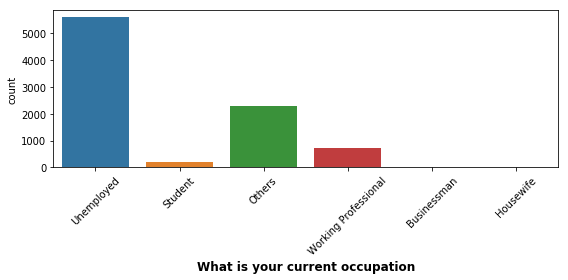

In [804]:
fig = plt.figure(figsize=(8,4))
sns.countplot(x="What is your current occupation",data=leads_df)
plt.xticks(rotation=45)
plt.xlabel("What is your current occupation",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()

In [805]:
# For What is your current occupation it is mostly Unemployed we can impute with it
leads_df["What is your current occupation"].fillna(value='Unemployed',inplace=True)

In [806]:
leads_df["What matters most to you in choosing a course"].value_counts()

Better Career Prospects      6518
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

Most frequent answer to question `What matters most to you in choosing a course` is "Better Career Prospects". This can be imputed in place of null values.

In [807]:
leads_df["What matters most to you in choosing a course"].replace({"Other":"Others",np.nan:"Others"},inplace=True)

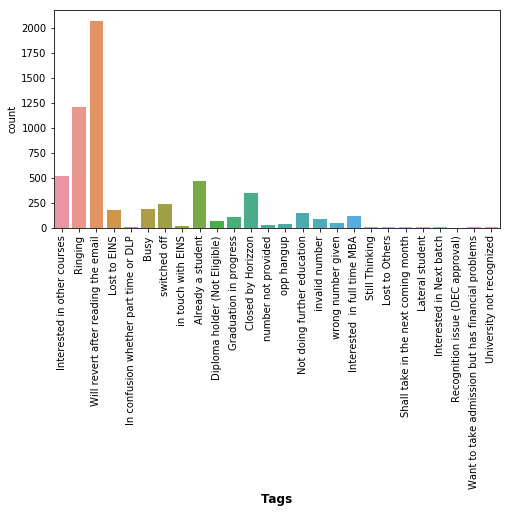

In [808]:
fig = plt.figure(figsize=(8,4))
ax = sns.countplot(x="Tags",data=leads_df)
plt.xticks(rotation=90)
plt.xlabel("Tags",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()

`Tags` column seem to have variety of data. So, it will be difficult to impute values in this column. So, it is better to drop this column.

In [809]:
# Removing Tags column 
leads_df.drop(columns="Tags",inplace=True)

In [810]:
# Dropping the City column as this will not be a major imapact in our business problem 
# and also Country will be corelated to City
leads_df.drop(columns='City',inplace=True)

In [811]:
# Drop rows with missing values
leads_df.dropna(axis=0,inplace=True)

In [812]:

# Calculate % of missing values in each dataset
round(100*(leads_df.isnull().sum()/len(leads_df.index)), 2)

Prospect ID                                      0.0
Lead Number                                      0.0
Lead Origin                                      0.0
Lead Source                                      0.0
Do Not Email                                     0.0
Do Not Call                                      0.0
Converted                                        0.0
TotalVisits                                      0.0
Total Time Spent on Website                      0.0
Page Views Per Visit                             0.0
Last Activity                                    0.0
Country                                          0.0
Specialization                                   0.0
How did you hear about X Education               0.0
What is your current occupation                  0.0
What matters most to you in choosing a course    0.0
Search                                           0.0
Magazine                                         0.0
Newspaper Article                             

**All the missing values are either imputed or removed from dataset.**

In [813]:
leads_df.shape

(8669, 30)

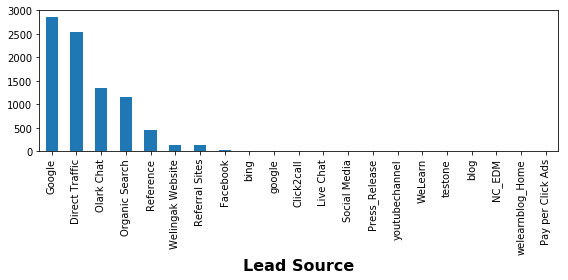

In [814]:
fig=plt.figure(figsize=(8,4))
leads_df['Lead Source'].value_counts().plot(kind='bar')
plt.xlabel("Lead Source",fontsize=16,fontweight='bold')
plt.tight_layout()
fig.show()

### Outliers analysis

In [815]:
#Looking at the int,float,object types
leads_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8669 entries, 0 to 9239
Data columns (total 30 columns):
Prospect ID                                      8669 non-null object
Lead Number                                      8669 non-null int64
Lead Origin                                      8669 non-null object
Lead Source                                      8669 non-null object
Do Not Email                                     8669 non-null object
Do Not Call                                      8669 non-null object
Converted                                        8669 non-null int64
TotalVisits                                      8669 non-null float64
Total Time Spent on Website                      8669 non-null int64
Page Views Per Visit                             8669 non-null float64
Last Activity                                    8669 non-null object
Country                                          8669 non-null object
Specialization                                   8669 

In [816]:
leads_df.describe(percentiles=[.025,.5,.75,.8,.9,.95,.99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,8669.000000,8669.000000,8669.000000,8669.000000,8669.000000
mean,617121.545968,0.392433,3.613104,504.743454,2.479183
std,23765.460081,0.488320,4.911026,547.515388,2.149064
min,579533.000000,0.000000,0.000000,0.000000,0.000000
2.5%,581213.100000,0.000000,0.000000,0.000000,0.000000
50%,615326.000000,0.000000,3.000000,267.000000,2.000000
75%,638014.000000,1.000000,5.000000,953.000000,3.500000
80%,642029.600000,1.000000,5.000000,1104.400000,4.000000
90%,650789.200000,1.000000,7.000000,1387.000000,5.000000
95%,655496.600000,1.000000,10.000000,1566.000000,6.000000


`TotalVisits` and `Page Views Per Visit` looks like are having outliers

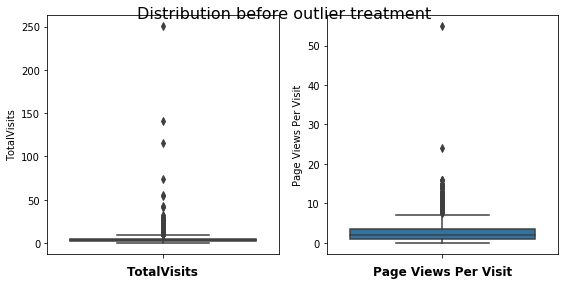

In [817]:
#Box plots to view the same
fig=plt.figure(figsize=(8,4))
plt.subplot(121)
ax = sns.boxplot(x="TotalVisits",data=leads_df,orient='v')
plt.xlabel("TotalVisits",fontsize=12,fontweight='bold')
plt.xticks(rotation=45)
plt.subplot(122)
ax = sns.boxplot(x="Page Views Per Visit",data=leads_df,orient='v')
plt.xlabel("Page Views Per Visit",fontsize=12,fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
fig.suptitle('Distribution before outlier treatment', fontsize=16)
fig.show()

### Outlier treatment

In [818]:
#Removing the rows which are above 99% of total values
q = leads_df['TotalVisits'].quantile(.95)
leads_df = leads_df[leads_df['TotalVisits']<=q]

In [819]:
#Removing the rows which are above 99% of total values
q = leads_df['Page Views Per Visit'].quantile(.95)
leads_df = leads_df[leads_df['Page Views Per Visit']<=q]

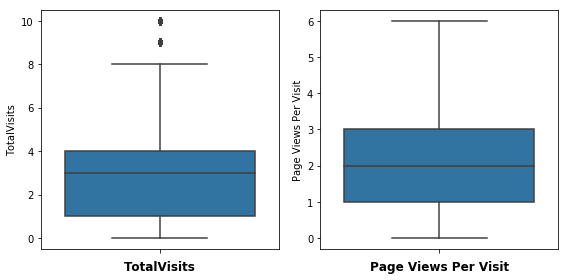

In [820]:
fig=plt.figure(figsize=(8,4))
plt.subplot(121)
ax = sns.boxplot(x="TotalVisits",data=leads_df,orient='v')
plt.xlabel("TotalVisits",fontsize=12,fontweight='bold')
plt.subplot(122)
ax = sns.boxplot(x="Page Views Per Visit",data=leads_df,orient='v')
plt.xlabel("Page Views Per Visit",fontsize=12,fontweight='bold')
plt.tight_layout()
fig.show()

In [821]:
#Now the values looks ok
leads_df.describe(percentiles=[.025,.5,.75,.8,.9,.95,.99])

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,8041.000000,8041.000000,8041.000000,8041.000000,8041.000000
mean,617093.316876,0.389504,2.889939,491.463748,2.174379
std,23735.927279,0.487668,2.304484,544.557486,1.622947
min,579533.000000,0.000000,0.000000,0.000000,0.000000
2.5%,581179.000000,0.000000,0.000000,0.000000,0.000000
50%,615502.000000,0.000000,3.000000,255.000000,2.000000
75%,637927.000000,1.000000,4.000000,934.000000,3.000000
80%,641934.000000,1.000000,5.000000,1090.000000,4.000000
90%,650488.000000,1.000000,6.000000,1378.000000,4.000000
95%,655403.000000,1.000000,7.000000,1557.000000,5.000000


### Data preparation

###### Binary and onehot encoding

In [822]:
#Looking for coloums that have binary encoding like 'Yes',"No" and storing the coloums name that matches this criteria
#Also storing the columns names that would be easily remembered one-hot encoding
columns = list(leads_df.columns)
binary = []
onehot = []
for i in columns:
    if (leads_df[i].dtype) == 'object':
        if len(list((leads_df[i].value_counts()))) == 2:
            #print(leads_df[i].value_counts())
            binary.append(i)
        else:
            onehot.append(i)

Since all the Binary encoding Columns have Yes and No we can write a generic code to change it to 1 and 0 respectively

In [823]:
#Binary encoding changing Yes to 1 and No to 0 and type as int
for i in binary:
    leads_df[i] = leads_df[i].map({'No':0,'Yes':1})
    leads_df[i] = leads_df[i].astype('int')

In [824]:
#Looking at the distinct values in each column
for i in onehot:
    print(i,'-->',len(list(leads_df[i].value_counts())))

Prospect ID --> 8041
Lead Origin --> 4
Lead Source --> 21
Last Activity --> 17
Country --> 38
Specialization --> 19
How did you hear about X Education --> 9
What is your current occupation --> 6
What matters most to you in choosing a course --> 3
Magazine --> 1
Newspaper Article --> 1
X Education Forums --> 1
Receive More Updates About Our Courses --> 1
Lead Quality --> 5
Update me on Supply Chain Content --> 1
Get updates on DM Content --> 1
I agree to pay the amount through cheque --> 1
Last Notable Activity --> 16


Here `Magazine` and `X Education Forums` are of one catogery **Indicating whether the customer had seen the ad in any of the listed items** along with `Search`,`Newspaper Article`,`Newspaper`,`Digital Advertisement`. Hence it is like one-hot encoding hence we can delete one colum and can change one colum value to 0

And since `Receive More Updates About Our Courses` , `Update me on Supply Chain Content` ,`Get updates on DM Content`, `I agree to pay the amount through cheque` has same value across all the rows, proceeding with deleteing those columns

In [825]:
#deleting X Education Forums and changing the Magazine values to 0 and astype to int
leads_df.drop(columns='X Education Forums',axis=1,inplace=True)
leads_df['Magazine'] =leads_df['Magazine'].map({'No':0})
leads_df['Magazine'] = leads_df['Magazine'].astype('int')

In [826]:
#Since 'Receive More Updates About Our Courses' , 'Update me on Supply Chain Content' ,Get updates on DM Content', 'I agree to pay the amount through cheque' has same value across all rows deleting those colums
leads_df.drop(columns=['Newspaper Article','Receive More Updates About Our Courses','Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque'],axis=1,inplace=True)

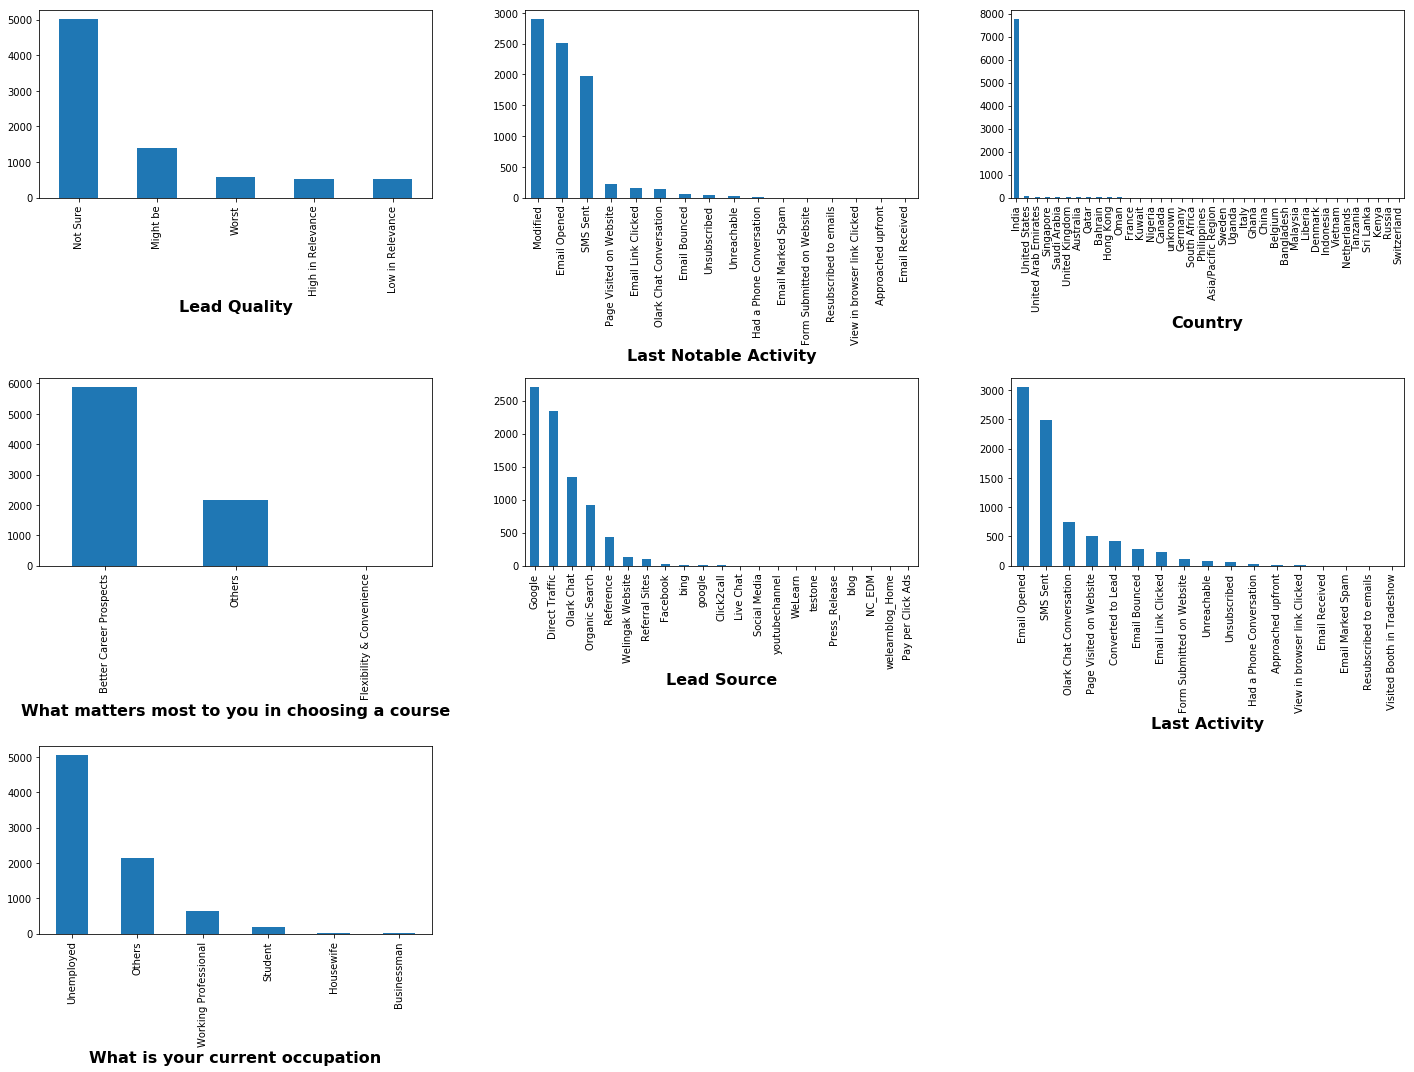

In [827]:
var_list = ["Lead Quality","Last Notable Activity","Country","What matters most to you in choosing a course",
           "Lead Source","Last Activity","What is your current occupation"]

fig = plt.figure(figsize=(20,15))
for i in range(len(var_list)):
    plt.subplot(3,3,i+1)
    leads_df[var_list[i]].value_counts().plot(kind='bar')
    plt.xlabel(var_list[i],fontsize=16,fontweight='bold')
    plt.xticks(rotation=90)
plt.tight_layout()
fig.show()    

In [828]:
#% of the columns having India as country
len(leads_df[leads_df.Country == 'India'])/len(leads_df)*100

96.67951747295113

Here since 97% of the columns are India it make sense that expect India all other countries can be merged and name as Other countries. Now here we can use the concept of binary ecoding Saying India as 1 and rest all as 0

In [829]:
#binary econding for Country
def country(x):
    if x['Country'] == 'India':
        return 1
    else:
        return 0
leads_df['Country'] = leads_df.apply(country,axis=1)
#Changing the type to int
leads_df['Country'] = leads_df['Country'].astype('int')

In [830]:
leads_df['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      5889
Others                       2151
Flexibility & Convenience       1
Name: What matters most to you in choosing a course, dtype: int64

Here since <b><i>Flexiblity & Concenience</i></b> is just 1 row we can consider it in other then it becomes Binary ecoding and <b><i>Better Carrer Prospects</i></b> takes 1 and <b><i>Other</i></b> takes 0

In [831]:
def choosing(x):
    if x['What matters most to you in choosing a course'] == 'Better Career Prospects':
        return 1
    else:
        return 0
leads_df['What matters most to you in choosing a course'] = leads_df.apply(choosing,axis=1)
#Changing the type to int
leads_df['What matters most to you in choosing a course'] = leads_df['What matters most to you in choosing a course'].astype('int')

As per above chart, columns `Last Notable Activity`,`Lead Source`,`Last Activity` and `What is your current occupation` contains values with too less value counts. These values can be moved to **Others** category in order to reduce number of variables after one hot encoding 

In [832]:
print("Lead Source column after BEFORE cleansing..")
print("----------------------------------------------")
leads_df['Lead Source'].value_counts()

Lead Source column after BEFORE cleansing..
----------------------------------------------


Google               2709
Direct Traffic       2349
Olark Chat           1338
Organic Search        919
Reference             440
Welingak Website      128
Referral Sites        102
Facebook               30
bing                    6
google                  5
Click2call              3
Live Chat               2
Social Media            2
youtubechannel          1
WeLearn                 1
testone                 1
Press_Release           1
blog                    1
NC_EDM                  1
welearnblog_Home        1
Pay per Click Ads       1
Name: Lead Source, dtype: int64

In [833]:
leads_df['Lead Source'] = leads_df['Lead Source'].replace({'google':'Google'})
lis = ['Facebook','bing','Click2call','Live Chat','Social Media','WeLearn','NC_EDM','welearnblog_Home','blog','Pay per Click Ads','testone','youtubechannel','Press_Release']
def change(x):
    if x['Lead Source'] in lis:
        return 'Others'
    else:
        return x['Lead Source']
leads_df['Lead Source'] = leads_df.apply(change,axis=1)

In [834]:
print("Lead Source column after AFTER cleansing..")
print("----------------------------------------------")
leads_df['Lead Source'].value_counts()

Lead Source column after AFTER cleansing..
----------------------------------------------


Google              2714
Direct Traffic      2349
Olark Chat          1338
Organic Search       919
Reference            440
Welingak Website     128
Referral Sites       102
Others                51
Name: Lead Source, dtype: int64

In [835]:
print("Last Activity column after BEFORE cleansing..")
print("----------------------------------------------")
print(leads_df["Last Activity"].value_counts())

Last Activity column after BEFORE cleansing..
----------------------------------------------
Email Opened                    3055
SMS Sent                        2492
Olark Chat Conversation          754
Page Visited on Website          502
Converted to Lead                425
Email Bounced                    291
Email Link Clicked               238
Form Submitted on Website        110
Unreachable                       83
Unsubscribed                      56
Had a Phone Conversation          20
Approached upfront                 5
View in browser link Clicked       4
Email Received                     2
Email Marked Spam                  2
Resubscribed to emails             1
Visited Booth in Tradeshow         1
Name: Last Activity, dtype: int64


In [836]:
# values "Had a Phone Conversation","Approached upfront","View in browser link Clicked",
#"Email Marked Spam","Email Received","Visited Booth in Tradeshow","Resubscribed to emails"
# are having values less than or equals 20. So, all values can be categorized as Others
lis = ["Had a Phone Conversation","Approached upfront","View in browser link Clicked",\
       "Email Marked Spam","Email Received","Visited Booth in Tradeshow","Resubscribed to emails"]
def change(x):
    if x['Last Activity'] in lis:
        return 'Others'
    else:
        return x['Last Activity']
leads_df['Last Activity'] = leads_df.apply(change,axis=1)

In [837]:
print("Last Activity column AFTER data cleansing..")
print("----------------------------------------------")
print(leads_df["Last Activity"].value_counts())

Last Activity column AFTER data cleansing..
----------------------------------------------
Email Opened                 3055
SMS Sent                     2492
Olark Chat Conversation       754
Page Visited on Website       502
Converted to Lead             425
Email Bounced                 291
Email Link Clicked            238
Form Submitted on Website     110
Unreachable                    83
Unsubscribed                   56
Others                         35
Name: Last Activity, dtype: int64


In [838]:
print("What is your current occupation column BEFORE data cleansing..")
print("----------------------------------------------")
print(leads_df["What is your current occupation"].value_counts())

What is your current occupation column BEFORE data cleansing..
----------------------------------------------
Unemployed              5056
Others                  2144
Working Professional     630
Student                  197
Housewife                  9
Businessman                5
Name: What is your current occupation, dtype: int64


In [839]:
# Values "Housewife","Businessman" have values less than 10. So they can be classified as "Others" for variables reduction. 
lis = ["Housewife","Businessman"]
def change(x):
    if x['What is your current occupation'] in lis:
        return 'Others'
    else:
        return x['What is your current occupation']
leads_df['What is your current occupation'] = leads_df.apply(change,axis=1)

In [840]:
print("What is your current occupation column AFTER data cleansing..")
print("----------------------------------------------")
print(leads_df["What is your current occupation"].value_counts())

What is your current occupation column AFTER data cleansing..
----------------------------------------------
Unemployed              5056
Others                  2158
Working Professional     630
Student                  197
Name: What is your current occupation, dtype: int64


In [841]:
print("Last Notable Activity column BEFORE data cleansing..")
print("----------------------------------------------")
print(leads_df["Last Notable Activity"].value_counts())

Last Notable Activity column BEFORE data cleansing..
----------------------------------------------
Modified                        2903
Email Opened                    2507
SMS Sent                        1973
Page Visited on Website          227
Email Link Clicked               149
Olark Chat Conversation          135
Email Bounced                     59
Unsubscribed                      42
Unreachable                       29
Had a Phone Conversation          10
Email Marked Spam                  2
Form Submitted on Website          1
Resubscribed to emails             1
View in browser link Clicked       1
Approached upfront                 1
Email Received                     1
Name: Last Notable Activity, dtype: int64


In [842]:
# Values "Had a Phone Conversation","Email Marked Spam","View in browser link Clicked","Form Submitted on Website","Email Received",
# "Approached upfront","Resubscribed to emails" have values less than 10. 
# So they can be classified as "Others" for variables reduction. 

lis = ["Had a Phone Conversation","Email Marked Spam","View in browser link Clicked","Form Submitted on Website","Email Received",\
       "Approached upfront","Resubscribed to emails"]
def change(x):
    if x['Last Notable Activity'] in lis:
        return 'Others'
    else:
        return x['Last Notable Activity']
leads_df['Last Notable Activity'] = leads_df.apply(change,axis=1)

In [843]:
print("Last Notable Activity column AFTER data cleansing..")
print("----------------------------------------------")
print(leads_df["Last Notable Activity"].value_counts())

Last Notable Activity column AFTER data cleansing..
----------------------------------------------
Modified                   2903
Email Opened               2507
SMS Sent                   1973
Page Visited on Website     227
Email Link Clicked          149
Olark Chat Conversation     135
Email Bounced                59
Unsubscribed                 42
Unreachable                  29
Others                       17
Name: Last Notable Activity, dtype: int64


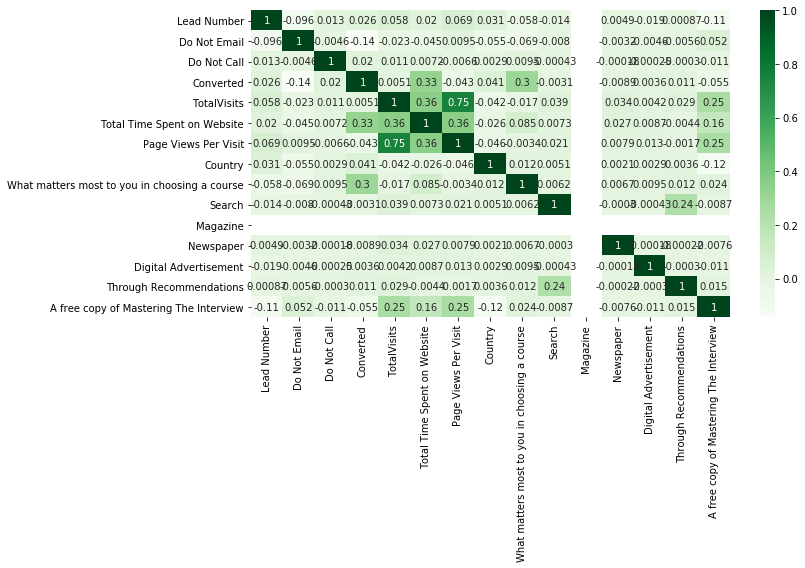

In [844]:
plt.figure(figsize=(12,8))
sns.heatmap(leads_df.corr(),cmap='Greens',annot=True)
plt.tight_layout()
fig.show()

In [845]:
#deleting Page Views per visit as this is highly corelated to TotalVisits
#Last Notable Activity we are deleting because the Last Notable Activity and Last Activity is corelated and it is expained below
leads_df.drop(columns={'Page Views Per Visit','Last Notable Activity'},axis=1,inplace=True)

In [846]:
# Defining a reusable function to map dummies
def get_dummies(df,col_name):
    dummy = pd.get_dummies(df[col_name], prefix=col_name,drop_first=True)
    df = pd.concat([df,dummy], axis=1)
    df = df.drop(columns=col_name,axis=1)
    return df

In [847]:
leads_df = get_dummies(leads_df,"Lead Origin")
leads_df = get_dummies(leads_df,"Lead Source")
leads_df = get_dummies(leads_df,"Last Activity")
leads_df = get_dummies(leads_df,"Specialization")
leads_df = get_dummies(leads_df,"How did you hear about X Education")
leads_df = get_dummies(leads_df,"What is your current occupation")
leads_df = get_dummies(leads_df,"Lead Quality")


In [848]:
#checking if there are any columns that are having same values in all rows
cols = leads_df.columns
for i in cols:
    if len(list(dict(leads_df[i].value_counts()))) == 1:
        print(i)

Magazine


In [849]:
# Dropping "Prospect ID","Lead Number" as they are just customer identifiers and will not help much in modelling
#Magazine we are deleting because we saw that it contain same values
final_leads_df = leads_df.drop(columns={"Prospect ID","Lead Number","Magazine"})
final_leads_df.shape

(8041, 65)

###### Train-Test split and scaling

In [850]:
answer = final_leads_df["Converted"]
answer = pd.DataFrame(data=answer)
answer.shape

final_leads_df.drop(columns="Converted",axis=1,inplace=True)

In [851]:
#Doing the train-test split
x_train,x_test,y_train,y_test = train_test_split(final_leads_df,answer,train_size=0.7,random_state=100)

In [852]:
#Setting up the display options 
pd.set_option('display.max_columns',75)

In [853]:
#seeing the describe we need to scale below colums
x_train.describe()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Country,What matters most to you in choosing a course,Search,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_Online Search,How did you hear about X Education_Others,How did you hear about X Education_SMS,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst
count,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.0,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000
mean,0.076759,0.000178,2.865849,490.214463,0.967306,0.729566,0.000711,0.0,0.000178,0.000355,0.312722,0.542999,0.071784,0.004087,0.335643,0.168977,0.113362,0.007463,0.054371,0.011727,0.016169,0.036603,0.027363,0.375444,0.014037,0.096482,0.003731,0.063255,0.312722,0.011372,0.006574,0.043355,0.006219,0.012438,0.113006,0.014748,0.011194,0.092040,0.043888,0.019900,0.097548,0.022033,0.060235,0.347193,0.011372,0.006930,0.004620,0.037846,0.020256,0.003198,0.019190,0.090085,0.794421,0.002843,0.006752,0.035714,0.039446,0.023810,0.625444,0.080490,0.066098,0.172886,0.625267,0.068941
std,0.266232,0.013330,2.304897,543.388509,0.177849,0.444223,0.026652,0.0,0.013330,0.018849,0.463643,0.498192,0.258153,0.063802,0.472257,0.374764,0.317063,0.086072,0.226768,0.107664,0.126137,0.187801,0.163154,0.484280,0.117654,0.295277,0.060976,0.243443,0.463643,0.106040,0.080822,0.203672,0.078621,0.110839,0.316629,0.120552,0.105217,0.289108,0.204863,0.139671,0.296729,0.146803,0.237942,0.476120,0.106040,0.082963,0.067818,0.190842,0.140887,0.056468,0.137204,0.286329,0.404160,0.053248,0.081900,0.185593,0.194670,0.152469,0.484051,0.272075,0.248476,0.378182,0.484097,0.253376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

Scaling is required on `TotalVisits`,`Total Time Spent on Website`. Here minmax scaler makes more sense than standard scaler since all the other values are packed between 0 &1 min-max scaler also packes the values between 0 and 1

In [854]:
scaler = MinMaxScaler()
x_train[['TotalVisits','Total Time Spent on Website']] = scaler.fit_transform(x_train[['TotalVisits','Total Time Spent on Website']])

#### Applying scaling on test dataset

In [855]:
x_test[['TotalVisits','Total Time Spent on Website']] = scaler.transform(x_test[['TotalVisits','Total Time Spent on Website']])

In [856]:
x_train.describe()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Country,What matters most to you in choosing a course,Search,Newspaper,Digital Advertisement,Through Recommendations,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,How did you hear about X Education_Email,How did you hear about X Education_Multiple Sources,How did you hear about X Education_Online Search,How did you hear about X Education_Others,How did you hear about X Education_SMS,How did you hear about X Education_Social Media,How did you hear about X Education_Student of SomeSchool,How did you hear about X Education_Word Of Mouth,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst
count,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.0,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000,5628.000000
mean,0.076759,0.000178,0.286585,0.217583,0.967306,0.729566,0.000711,0.0,0.000178,0.000355,0.312722,0.542999,0.071784,0.004087,0.335643,0.168977,0.113362,0.007463,0.054371,0.011727,0.016169,0.036603,0.027363,0.375444,0.014037,0.096482,0.003731,0.063255,0.312722,0.011372,0.006574,0.043355,0.006219,0.012438,0.113006,0.014748,0.011194,0.092040,0.043888,0.019900,0.097548,0.022033,0.060235,0.347193,0.011372,0.006930,0.004620,0.037846,0.020256,0.003198,0.019190,0.090085,0.794421,0.002843,0.006752,0.035714,0.039446,0.023810,0.625444,0.080490,0.066098,0.172886,0.625267,0.068941
std,0.266232,0.013330,0.230490,0.241184,0.177849,0.444223,0.026652,0.0,0.013330,0.018849,0.463643,0.498192,0.258153,0.063802,0.472257,0.374764,0.317063,0.086072,0.226768,0.107664,0.126137,0.187801,0.163154,0.484280,0.117654,0.295277,0.060976,0.243443,0.463643,0.106040,0.080822,0.203672,0.078621,0.110839,0.316629,0.120552,0.105217,0.289108,0.204863,0.139671,0.296729,0.146803,0.237942,0.476120,0.106040,0.082963,0.067818,0.190842,0.140887,0.056468,0.137204,0.286329,0.404160,0.053248,0.081900,0.185593,0.194670,0.152469,0.484051,0.272075,0.248476,0.378182,0.484097,0.253376
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,

##### Corelation check

In [857]:
def find_highly_corr_cols(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr() 
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if ((corr_matrix.iloc[i, j] <= -1*threshold) or (corr_matrix.iloc[i, j] >= threshold)) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [858]:
final_leads_df.corr().unstack().sort_values().drop_duplicates()

Lead Origin_Landing Page Submission                  Specialization_Others                                      -0.741066
How did you hear about X Education_Online Search     How did you hear about X Education_Others                  -0.622118
Lead Quality_Not Sure                                Lead Quality_Might be                                      -0.592634
Last Activity_SMS Sent                               Last Activity_Email Opened                                 -0.524561
Lead Source_Google                                   How did you hear about X Education_Others                  -0.514831
Lead Source_Olark Chat                               TotalVisits                                                -0.496850
Lead Origin_Landing Page Submission                  Lead Source_Olark Chat                                     -0.492008
Specialization_Others                                A free copy of Mastering The Interview                     -0.490136
What matters most to you

Now here we are seeing that `Last Activity` and `Last Notable Activity` are co-related. So, we will be deleting them in **final_leads_df** dataset and run the cells from there so that we dont need to delete many rows .
Also we have below co-related rows

`What matters most to you in choosing a course` <-> `What is your current occupation_Unemployed`                  `0.785578`

`Lead Origin_Lead Add Form`                            `Lead Source_Reference`                                     `0.866153`

`Lead Origin_Landing Page Submission`                  `Specialization_Others`                                      `-0.741066`

Hence deleting the `What matters most to you in choosing a course`,`Specialization_Others`,`Lead Origin_Lead Add Form` from test and train datasets

In [859]:
print("x_train size before dropping columns :",x_train.shape)

col_corr = find_highly_corr_cols(final_leads_df,0.70) 
for colname in col_corr:  
    if colname in x_train.columns:
        print("Deleting column",colname,"from x_train dataset..")
        del x_train[colname] # deleting the column from the dataset
    if colname in x_test.columns:
        print("Deleting column",colname,"from x_test dataset..")
        del x_test[colname]

print("x_train size after dropping columns :",x_train.shape)

x_train size before dropping columns : (5628, 64)
Deleting column Lead Source_Others from x_train dataset..
Deleting column Lead Source_Others from x_test dataset..
Deleting column Lead Source_Reference from x_train dataset..
Deleting column Lead Source_Reference from x_test dataset..
Deleting column Specialization_Others from x_train dataset..
Deleting column Specialization_Others from x_test dataset..
Deleting column What is your current occupation_Unemployed from x_train dataset..
Deleting column What is your current occupation_Unemployed from x_test dataset..
x_train size after dropping columns : (5628, 60)


In [860]:
#Looking at the co-relation once again
x_train.corr().unstack().sort_values().drop_duplicates()

How did you hear about X Education_Others             How did you hear about X Education_Online Search           -0.618532
Lead Quality_Might be                                 Lead Quality_Not Sure                                      -0.590565
Last Activity_Email Opened                            Last Activity_SMS Sent                                     -0.522998
Lead Source_Google                                    How did you hear about X Education_Others                  -0.510852
TotalVisits                                           Lead Source_Olark Chat                                     -0.498383
Lead Source_Olark Chat                                Lead Origin_Landing Page Submission                        -0.491527
What matters most to you in choosing a course         Lead Quality_Not Sure                                      -0.469679
How did you hear about X Education_Word Of Mouth      How did you hear about X Education_Others                  -0.398359
How did you hear

# Model Bulding

### Feature Selection Using RFE

In [861]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [862]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)             
rfe = rfe.fit(x_train, y_train)

In [863]:
col = x_train.columns[rfe.support_]
col

Index(['Do Not Email', 'Total Time Spent on Website',
       'Lead Origin_Lead Add Form', 'Lead Source_Olark Chat',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Last Activity_Others', 'Last Activity_SMS Sent',
       'Specialization_Services Excellence',
       'How did you hear about X Education_Email',
       'How did you hear about X Education_SMS',
       'What is your current occupation_Working Professional',
       'Lead Quality_Might be', 'Lead Quality_Not Sure', 'Lead Quality_Worst'],
      dtype='object')

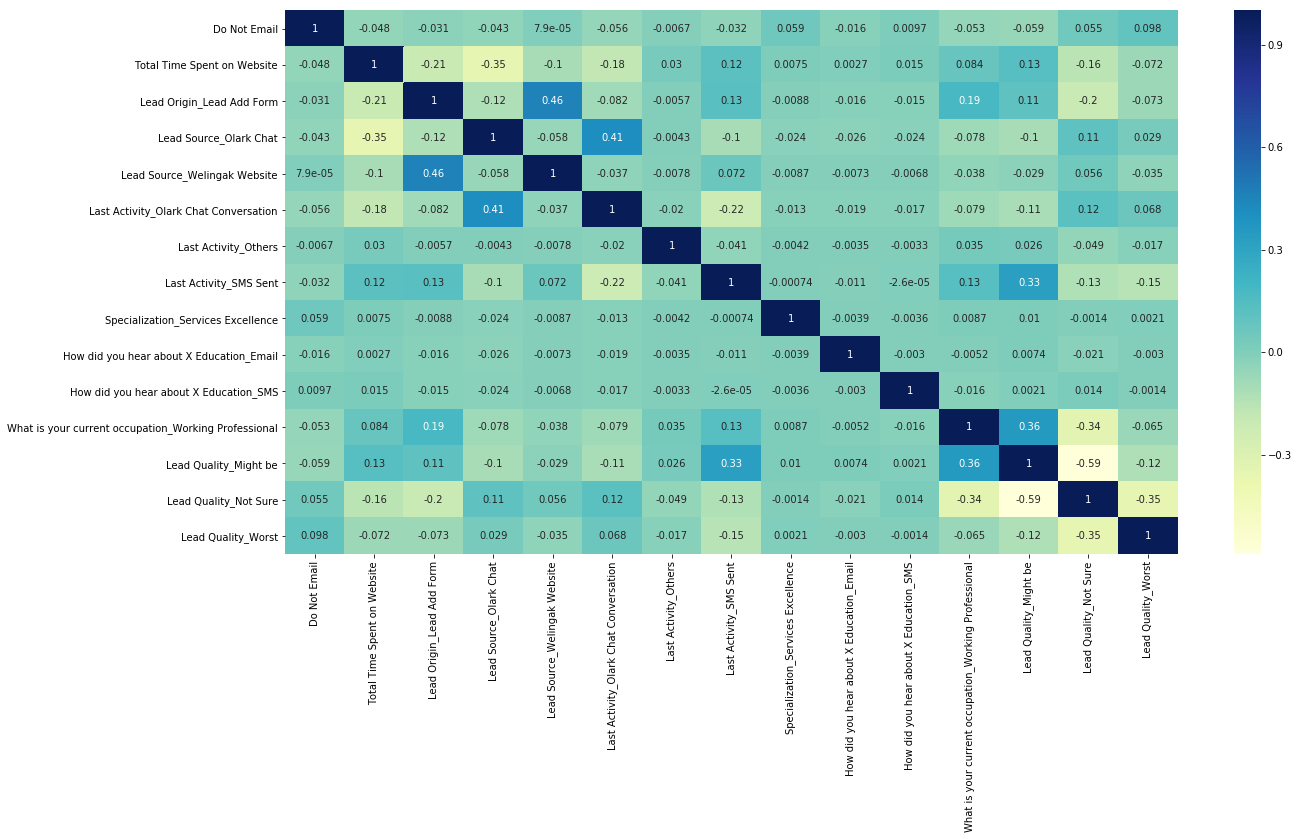

In [864]:
# Correlation heatmap to identify colinearity between RFE selected independent variables
corr = x_train[col].corr()

fig = plt.figure(figsize=(20,10))
sns.heatmap(corr,cmap="YlGnBu",annot=True)

fig.show()

From the above heatmap, we can see that
1. `Lead Quality_Might be` and `Lead Quality_Not Sure` seem to have negative correlation. But correlation index is not much to enable us to drop one of the variables.

Apart from these, we can not see very high correlation between variables. So, we can go ahead with these columns selection.

### Assessing the model with StatsModels

In [902]:
#Defining a reusable function to build model
def build_model(X_train,y_train):
    X_train_sm = sm.add_constant(X_train) 
    log_model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
    res = log_model.fit()
    print(res.summary())
    return X_train_sm   

In [866]:
X_train_rfe1 = build_model(x_train[col],y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5612
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.6
Date:                Mon, 26 Aug 2019   Deviance:                       4009.2
Time:                        14:07:37   Pearson chi2:                 5.93e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

**Variable `How did you hear about X Education_SMS` has high p-value and is thus insignificant. So, this variable should be removed from the model.**

We will drop `How did you hear about X Education_SMS`variable and rebuild the model with remaining variables.

In [867]:
X_train_rfe2 = X_train_rfe1.drop(columns=["How did you hear about X Education_SMS"],axis=1)
X_train_rfe2 = build_model(X_train_rfe2,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5613
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2005.8
Date:                Mon, 26 Aug 2019   Deviance:                       4011.5
Time:                        14:07:37   Pearson chi2:                 5.94e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

**Variable `Specialization_Services Excellence` has high p-value and is thus insignificant.So, this variable should be removed from the model.**

We will drop `Specialization_Services Excellence`variable and rebuild the model with remaining variables.

In [868]:
X_train_rfe3 = X_train_rfe2.drop(columns=["Specialization_Services Excellence"],axis=1)
X_train_rfe3 = build_model(X_train_rfe3,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5614
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2006.7
Date:                Mon, 26 Aug 2019   Deviance:                       4013.5
Time:                        14:07:37   Pearson chi2:                 5.91e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

**Variable `How did you hear about X Education_Email` has high p-value and is thus insignificant.So, this variable should be removed from the model.**

We will drop `How did you hear about X Education_Email`variable and rebuild the model with remaining variables.

In [869]:
X_train_rfe4 = X_train_rfe3.drop(columns=["How did you hear about X Education_Email"],axis=1)
X_train_rfe4 = build_model(X_train_rfe4,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5615
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2007.9
Date:                Mon, 26 Aug 2019   Deviance:                       4015.8
Time:                        14:07:37   Pearson chi2:                 5.91e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

**Variable `Last Activity_Others` has high p-value and is thus insignificant.So, this variable should be removed from the model.**

We will drop `Last Activity_Others`variable and rebuild the model with remaining variables.

In [870]:
X_train_rfe5 = X_train_rfe4.drop(columns=["Last Activity_Others"],axis=1)
X_train_rfe5 = build_model(X_train_rfe5,y_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5616
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2009.3
Date:                Mon, 26 Aug 2019   Deviance:                       4018.7
Time:                        14:07:37   Pearson chi2:                 5.92e+03
No. Iterations:                     7   Covariance Type:             nonrobust
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                          

______________________________________________________________________________________________________
______________________________________________________________________________________________________
p-value of all the variables is 0. This means that there are no insignificant variables. 

Let's have a look at multicollinearity between these variables using VIF.
______________________________________________________________________________________________________
______________________________________________________________________________________________________

In [871]:
#if 'const' in X_train_rfe5.columns:
#    print("Deleting column",colname,"from dataset..")
#    del x_test[colname]

vif = pd.DataFrame()
vif['Features'] = X_train_rfe5.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe5.values, i) for i in range(X_train_rfe5.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,12.55
10,Lead Quality_Not Sure,2.59
9,Lead Quality_Might be,2.13
3,Lead Origin_Lead Add Form,1.63
11,Lead Quality_Worst,1.58
4,Lead Source_Olark Chat,1.39
2,Total Time Spent on Website,1.34
5,Lead Source_Welingak Website,1.33
6,Last Activity_Olark Chat Conversation,1.27
8,What is your current occupation_Working Profes...,1.23


______________________________________________________________________________________________________
______________________________________________________________________________________________________
VIF value for all the above variables is very low. This indicates that there is no multicollinearity between variables. 

**So, this can be considered our final model.**

Let's rerun the model once again to collect statistics.
______________________________________________________________________________________________________
______________________________________________________________________________________________________

In [872]:
# Let's re-run the model using the selected variables
X_train_rfe5 = sm.add_constant(X_train_rfe5)
logm3 = sm.GLM(y_train,X_train_rfe5, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5616
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2009.3
Date:                Mon, 26 Aug 2019   Deviance:                       4018.7
Time:                        14:07:37   Pearson chi2:                 5.92e+03
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.0825      0.141      0.584      0.559      -0.195       0.360
Do Not Email                                            -1.2053      0.193     -6.253      0.000      -1.583      -0.828
Total Time Spent on Website                              4.1958      0.187     22.388      0.000       3.829       4.563
Lead Origin_Lead Add Form                                2.6717      0.251     10.633      0.000       2.179       3.164
Lead Source_Olark Chat                                   1.8007      0.124     14.535      0.000       1.558       2.043
Lead Source_Welingak Website                             4.2081      1.041      4.043      0.000       2.168       6.248
Last Activity_Olark Chat Conversation                   -1.1846      0.183     -6.458      0.000      -1.544      -0.825
Last Activity_SMS Sent                                   1.2959      0.087     14.955      0.000       1.126       1.466
What is your current occupation_Working Professional     1.7316      0.216      8.016      0.000       1.308       2.155
Lead Quality_Might be                                   -1.3326      0.161     -8.295      0.000      -1.648      -1.018
Lead Quality_Not Sure                                   -3.0976      0.141    -21.978      0.000      -3.374      -2.821
Lead Quality_Worst                                      -5.1948      0.374    -13.893      0.000      -5.928      -4.462
========================================================================================================================
"""

### Making predictions on train set

In [873]:
y_train_pred = res.predict(X_train_rfe5).values.reshape(-1)

In [874]:
#Creating a dataframe with prospect id, converted and predicated values
y_train_dataframe = pd.DataFrame({'Converted':y_train['Converted'].values,'Conversion_Prob':y_train_pred})
y_train_dataframe['CustID'] = y_train.index
y_train_dataframe.head()

,Converted,Conversion_Prob,CustID
0,1,0.351027,3319
1,0,0.298370,3071
2,0,0.061326,8379
3,1,0.728776,5057
4,0,0.083248,380


In [875]:
#If the prob > 0.5 then 1 else 0
y_train_dataframe['Predicted'] = y_train_dataframe.Conversion_Prob.map(lambda x:1 if x>0.5 else 0)
y_train_dataframe.head()

,Converted,Conversion_Prob,CustID,Predicted
0,1,0.351027,3319,0
1,0,0.298370,3071,0
2,0,0.061326,8379,0
3,1,0.728776,5057,1
4,0,0.083248,380,0


In [876]:
#Confusion matrix
print(metrics.confusion_matrix(y_train_dataframe.Converted,y_train_dataframe.Predicted))

[[3026  389]
 [ 494 1719]]


In [877]:
#accuracy
print(metrics.accuracy_score(y_train_dataframe.Converted,y_train_dataframe.Predicted))

0.8431058990760484


We have got pretty good accuracy score for train dataset.
Let's check other metrics beyond **Accuracy** such as **Sensitivity** and **Specificity** to validate model strength.

### ROC curve

In [878]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [879]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_dataframe.Converted, y_train_dataframe.Predicted, drop_intermediate = False )

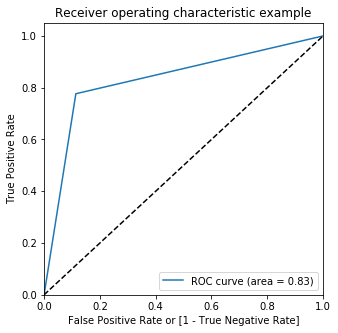

In [880]:
draw_roc(y_train_dataframe.Converted, y_train_dataframe.Predicted)

--------------------------------------------------------------------------------------------------

<b>Area under the curve is 0.83. This indicates that model has good measure of seperability.</b>

--------------------------------------------------------------------------------------------------




### Finding optimal cutoff point

In [881]:
numbers = [float(x/10) for x in range(10)]
for i in numbers:
    y_train_dataframe[i] = y_train_dataframe.Conversion_Prob.map(lambda x:1 if x>i else 0)

In [882]:
cut = pd.DataFrame(columns=['prob','accuracy','sensi','speci'])
for i in numbers:
    cm = metrics.confusion_matrix(y_train_dataframe.Converted,y_train_dataframe[i])
    total = sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    speci = cm[0,0]/(cm[0,0]+cm[0,1])
    sensi = cm[1,1]/(cm[1,0]+cm[1,1])
    cut.loc[i] = [i,accuracy,sensi,speci]

In [883]:
cut

,prob,accuracy,sensi,speci
0.0,0.0,0.393213,1.000000,0.000000
0.1,0.1,0.732942,0.968369,0.580381
0.2,0.2,0.783227,0.935382,0.684627
0.3,0.3,0.830490,0.852689,0.816105
0.4,0.4,0.840263,0.808857,0.860615
0.5,0.5,0.843106,0.776774,0.886091
0.6,0.6,0.832090,0.691369,0.923280
0.7,0.7,0.821429,0.616810,0.954026
0.8,0.8,0.805792,0.553095,0.969546
0.9,0.9,0.759240,0.408043,0.986823


--------------------------------------------------------------------------------------------------

As per above table, 0.3 seems to be a good cut-off point as it shows consistent <b><i>Accuracy</i></b>,<b><i>Sensitivity</i></b> and <b><i>Specificity</i></b> score. 

Let's try to plot these points on a graph.

--------------------------------------------------------------------------------------------------

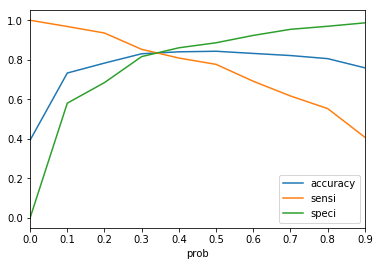

In [884]:
cut.plot.line(x='prob',y=['accuracy','sensi','speci'])

From the above 0.3 seems the optimal cut-off point

In [885]:
y_train_dataframe['finalConverted'] = y_train_dataframe.Conversion_Prob.map(lambda x: 1 if x>0.3 else 0)

In [886]:
cf = metrics.confusion_matrix(y_train_dataframe.Converted,y_train_dataframe.finalConverted)

In [887]:
print("Sensitivity",cf[1,1]/(float(cf[1,1]+cf[1,0])))
print("Specificity",cf[0,0]/(float(cf[0,0]+cf[0,1])))
print("Positive predication",cf[1,1]/float(cf[1,1]+cf[0,1]))
print("Negtive prediction",cf[0,0]/float(cf[0,0]+cf[1,0]))

Sensitivity 0.8526886579304112
Specificity 0.8161054172767204
Positive predication 0.7502982107355864
Negtive prediction 0.8952778670093158


**Predicted values shows decent balance of Sensitivity and Specificity.**

### Making predictions on test dataset

In [888]:
cols = list(X_train_rfe5.columns)

In [889]:
cols.remove('const')

In [890]:
x_test = x_test[cols]

In [891]:
x_test.describe()

,Do Not Email,Total Time Spent on Website,Lead Origin_Lead Add Form,Lead Source_Olark Chat,Lead Source_Welingak Website,Last Activity_Olark Chat Conversation,Last Activity_SMS Sent,What is your current occupation_Working Professional,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Worst
count,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000
mean,0.081227,0.219431,0.071281,0.160381,0.015334,0.087443,0.303357,0.073353,0.178201,0.622047,0.075010
std,0.273240,0.242954,0.257346,0.367035,0.122901,0.282542,0.459803,0.260769,0.382762,0.484976,0.263463
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.014647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.115846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.421216,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.008433,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [892]:
#Adding constant
x_test = sm.add_constant(x_test)
#Making Predictions
y_test_pred = res.predict(x_test)

In [893]:
y_test_dataframe = pd.DataFrame(y_test)

In [894]:
y_test_dataframe['Cust'] = y_test.index

In [895]:
y_test_dataframe['probality'] = y_test_pred

In [896]:
y_test_dataframe['finalConverted'] = y_test_dataframe.probality.map(lambda x:1 if x>0.3 else 0)

In [897]:
metrics.accuracy_score(y_test_dataframe.Converted,y_test_dataframe.finalConverted)

0.8329879817654372

In [898]:
y_test_dataframe.head()

,Converted,Cust,probality,finalConverted
2821,0,2821,0.055200,0
6183,0,6183,0.012914,0
9019,0,9019,0.430167,1
8547,1,8547,0.414986,1
5347,0,5347,0.008152,0


In [899]:
cf = metrics.confusion_matrix(y_test_dataframe.Converted,y_test_dataframe.finalConverted)
print("Sensitivity",cf[1,1]/(float(cf[1,1]+cf[1,0])))
print("Specificity",cf[0,0]/(float(cf[0,0]+cf[0,1])))
print("Positive predication",cf[1,1]/float(cf[1,1]+cf[0,1]))
print("Negtive prediction",cf[0,0]/float(cf[0,0]+cf[1,0]))

Sensitivity 0.8509249183895539
Specificity 0.821954484605087
Positive predication 0.7461832061068703
Negtive prediction 0.8996336996336997


**All the above metrics have values very close to what we got with train dataset. So, model's behaviour is consistent and it can be considered to be a good model.**

In [900]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 5628
Model:                            GLM   Df Residuals:                     5616
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2009.3
Date:                Mon, 26 Aug 2019   Deviance:                       4018.7
Time:                        14:07:38   Pearson chi2:                 5.92e+03
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.0825      0.141      0.584      0.559      -0.195       0.360
Do Not Email                                            -1.2053      0.193     -6.253      0.000      -1.583      -0.828
Total Time Spent on Website                              4.1958      0.187     22.388      0.000       3.829       4.563
Lead Origin_Lead Add Form                                2.6717      0.251     10.633      0.000       2.179       3.164
Lead Source_Olark Chat                                   1.8007      0.124     14.535      0.000       1.558       2.043
Lead Source_Welingak Website                             4.2081      1.041      4.043      0.000       2.168       6.248
Last Activity_Olark Chat Conversation                   -1.1846      0.183     -6.458      0.000      -1.544      -0.825
Last Activity_SMS Sent                                   1.2959      0.087     14.955      0.000       1.126       1.466
What is your current occupation_Working Professional     1.7316      0.216      8.016      0.000       1.308       2.155
Lead Quality_Might be                                   -1.3326      0.161     -8.295      0.000      -1.648      -1.018
Lead Quality_Not Sure                                   -3.0976      0.141    -21.978      0.000      -3.374      -2.821
Lead Quality_Worst                                      -5.1948      0.374    -13.893      0.000      -5.928      -4.462
========================================================================================================================
"""

<b>As per the model summary mentioned, we can say that following are few variables which we can use to optimize our conversion rate.
<i>
1. `Lead Source_Welingak Website`	- Highest positive standardized coefficient value
2. `Total Time Spent on Website`	- 2nd Highest standardized positive coefficient value
3. `Lead Origin_Lead Add Form`      - 3rd highest standardized positive coefficient value
4. `Lead Quality_Worst`             - Highest standardized negative coefficient value
</i>
Marketting team needs to concentrate on these variables to optimize our conversion rate.</b>